Importing Necessary Libraries & dataset

In [1]:
import pandas as pd
import numpy as np
import itertools
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import statsmodels.api as sm
from statsmodels.tsa import api as smt
from sklearn.neighbors import LocalOutlierFactor
import itertools
import warnings 

In [2]:
Beds = pd.read_csv('C:/Users/fast/Desktop/Project-P65/Project P65/Beds_Occupied.csv',index_col=False)

In [3]:
Beds.head()

,collection_date,Total Inpatient Beds
0,15-06-2020,293
1,16-06-2020,295
2,17-06-2020,290
3,18-06-2020,291
4,19-06-2020,288


In [4]:
Beds['Total Beds Available']=900-Beds['Total Inpatient Beds']
Beds.head()
# to get th total beds available

,collection_date,Total Inpatient Beds,Total Beds Available
0,15-06-2020,293,607
1,16-06-2020,295,605
2,17-06-2020,290,610
3,18-06-2020,291,609
4,19-06-2020,288,612


In [5]:
Beds = Beds.drop("Total Inpatient Beds",axis=1)

# EDA

In [6]:
Beds.collection_date = pd.to_datetime(Beds.collection_date, format= "%d-%m-%Y")
# for changing the datetime in proper format

In [7]:
Beds.set_index('collection_date', inplace=True)

In [8]:
Beds.index

DatetimeIndex(['2020-06-15', '2020-06-16', '2020-06-17', '2020-06-18',
               '2020-06-19', '2020-06-20', '2020-06-21', '2020-06-22',
               '2020-06-23', '2020-06-24',
               ...
               '2021-06-06', '2021-06-07', '2021-06-08', '2021-06-09',
               '2021-06-10', '2021-06-11', '2021-06-12', '2021-06-13',
               '2021-06-14', '2021-06-15'],
              dtype='datetime64[ns]', name='collection_date', length=359, freq=None)

In [9]:
Beds.dtypes # checking data type of columns

Total Beds Available    int64
dtype: object

In [10]:
dt = pd.date_range("06-15-2020","06-15-2021")
idx = pd.DatetimeIndex(dt)
df= Beds.reindex(idx)

In [11]:
pd.set_option('display.max_rows', df.shape[0]+1)
print(df)

            Total Beds Available
2020-06-15                 607.0
2020-06-16                 605.0
2020-06-17                 610.0
2020-06-18                 609.0
2020-06-19                 612.0
2020-06-20                 611.0
2020-06-21                 623.0
2020-06-22                 611.0
2020-06-23                 608.0
2020-06-24                 607.0
2020-06-25                 609.0
2020-06-26                 618.0
2020-06-27                 617.0
2020-06-28                 616.0
2020-06-29                 706.0
2020-06-30                 608.0
2020-07-01                 625.0
2020-07-02                 610.0
2020-07-03                 613.0
2020-07-04                 617.0
2020-07-05                 618.0
2020-07-06                 616.0
2020-07-07                 609.0
2020-07-08                 608.0
2020-07-09                 606.0
2020-07-10                 613.0
2020-07-11                 616.0
2020-07-12                 618.0
2020-07-13                 608.0
2020-07-14

In [12]:
#Any missing data?
print("missing_data:", df.isna().sum())
print("unique dates:", df.index.nunique())

missing_data: Total Beds Available    7
dtype: int64
unique dates: 366


In [13]:
df =df.interpolate(method='time')

In [14]:
#Checking missing data
print("missing_data:", df.isna().sum())
print("unique dates:", df.index.nunique())

missing_data: Total Beds Available    0
dtype: int64
unique dates: 366


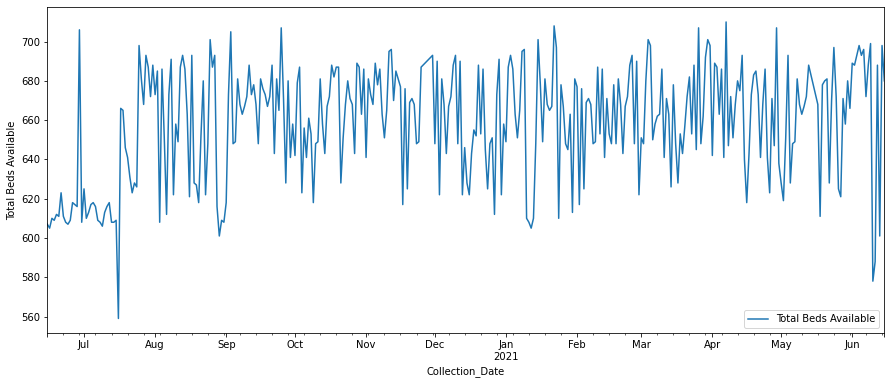

In [15]:
# line plot of time series
ax = df.plot.line(figsize=(15, 6))
# Specify the x-axis label in your plot
ax.set_xlabel('Collection_Date')
# Specify the y-axis label in your plot
ax.set_ylabel('Total Beds Available');
# From the plot we can see that the data is stationary.

Time Series Histogram and Density Plots

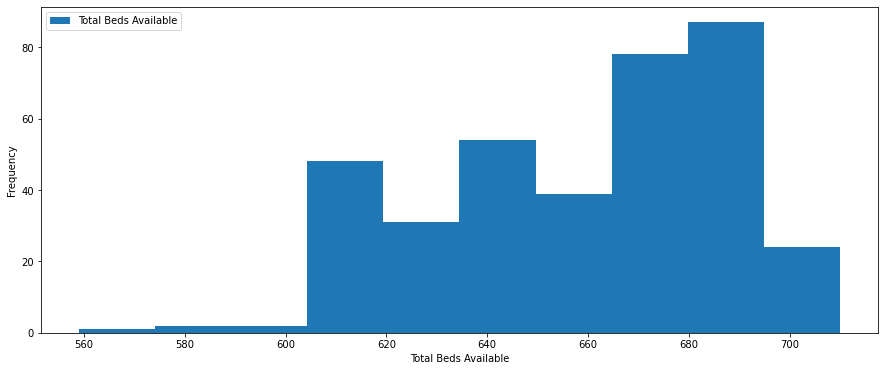

In [16]:
# Generate a histogram
ax = df.plot(kind='hist',figsize=(15, 6),fontsize=10)

# Set the labels and display the plot
ax.set_xlabel('Total Beds Available', fontsize=10)
plt.legend(fontsize=10)
plt.show();

# from histogram we can see that the data is negatively skewed and 670 to 690 beds are empty most of the times
# There are outliers in the dataset

Text(0, 0.5, 'Density plot of filled beds')

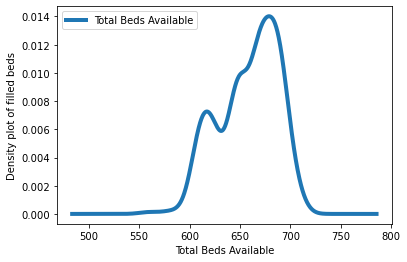

In [17]:
# Display density plot of total inpatient bed values
ax = df.plot(kind='density', linewidth=4, fontsize=10)

# Annotate x-axis labels
ax.set_xlabel('Total Beds Available', fontsize=10)

# Annotate y-axis labels
ax.set_ylabel('Density plot of filled beds', fontsize=10)

C:\Users\fast\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='Total Beds Available'>

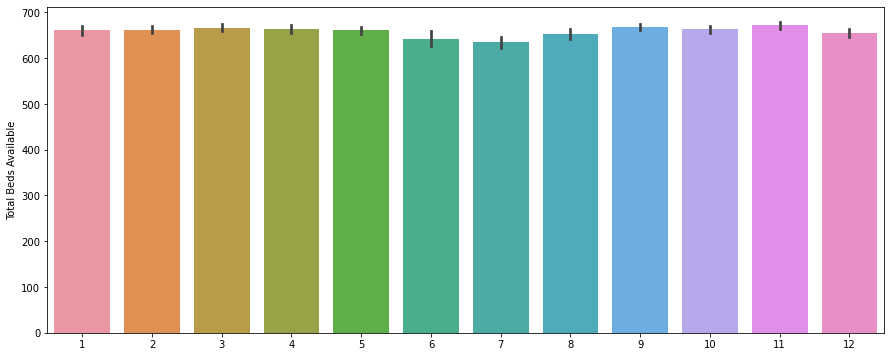

In [18]:
fig, ax = plt.subplots(figsize=(15,6))
sns.barplot(df['Total Beds Available'].index.month, df['Total Beds Available'], ax=ax)
# checking each months total inpatient beds count on bar chart

C:\Users\fast\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Total Beds Available'>

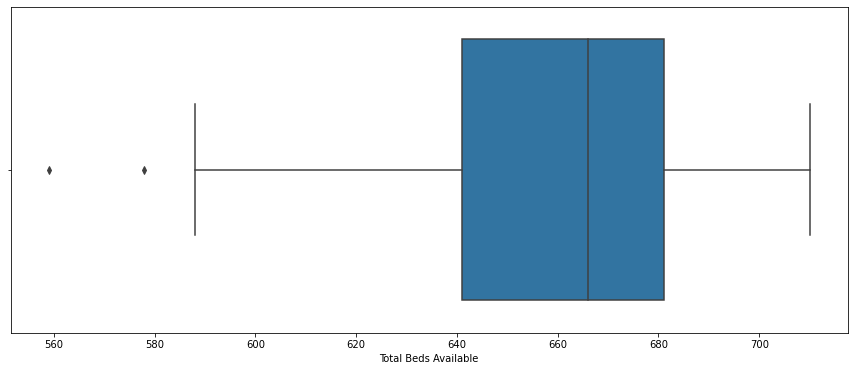

In [19]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(df['Total Beds Available'], ax=ax)
# We can see that there are outliers in the dataset

Detecting Outliers and Treating them

In [20]:
q1 = df['Total Beds Available'].quantile(0.25)
q3 = df['Total Beds Available'].quantile(0.75)
iqr = q3 - q1

In [21]:
low = q1-1.5*iqr
high = q3+1.5*iqr
print("Outliers = ",df.loc[(df['Total Beds Available'] < low) | (df['Total Beds Available'] > high), 'Total Beds Available'])

Outliers =  2020-07-16    559.0
2021-06-10    578.0
Freq: 329D, Name: Total Beds Available, dtype: float64


In [22]:
df['Total Beds Available'] = np.where(df['Total Beds Available']>high, high,
                                      np.where(df['Total Beds Available']<low, low, df['Total Beds Available']))

C:\Users\fast\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Total Beds Available'>

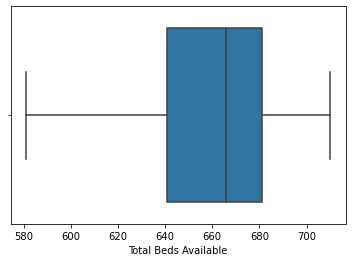

In [23]:
fig, ax = plt.subplots()
sns.boxplot(df['Total Beds Available'], ax=ax)

In [24]:
df.describe()

,Total Beds Available
count,366.000000
mean,658.598361
std,28.700015
min,581.000000
25%,641.000000
50%,666.000000
75%,681.000000
max,710.000000


Decomposing using statsmodel:

We can use statsmodels to perform a decomposition of this time series.
The decomposition of time series is a statistical task that deconstructs a time series into several components, each representing one of the underlying categories of patterns.
With statsmodels we will be able to see the trend, seasonal, and residual components of our data.

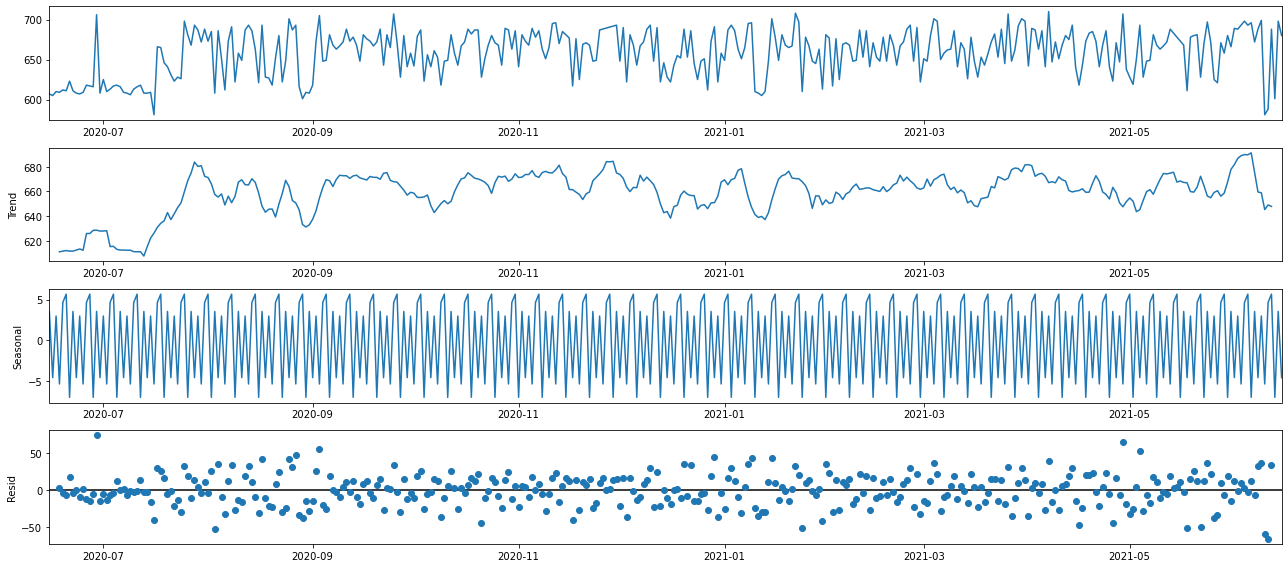

In [25]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df, model='Additive')
fig = decomposition.plot()
plt.show()
# we can see that the series is stationary

# Stationarity check

In [26]:
from statsmodels.tsa.stattools import adfuller 

In [27]:
df_series = df.squeeze()

In [28]:
type(df_series)

pandas.core.series.Series

In [29]:
adfuller(df_series)  

(-5.826977184256751,
 4.057800889565874e-07,
 4,
 361,
 {'1%': -3.4485948978753314,
  '5%': -2.86957971128312,
  '10%': -2.571053050314224},
 3263.4241804971225)

In [30]:

adfuller_results = pd.Series(adfuller(df_series)[:4],index=['T stats','p-value','lags used','Number of observations'])
for key,value in adfuller(df_series)[4].items():
    adfuller_results['Critical Value'+' '+ key] = value
print(adfuller_results)

T stats                  -5.826977e+00
p-value                   4.057801e-07
lags used                 4.000000e+00
Number of observations    3.610000e+02
Critical Value 1%        -3.448595e+00
Critical Value 5%        -2.869580e+00
Critical Value 10%       -2.571053e+00
dtype: float64


In [31]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

as the p-value is less than 0.05 we can say that series is stationary

Rolling mean method & ACF & PACF plot

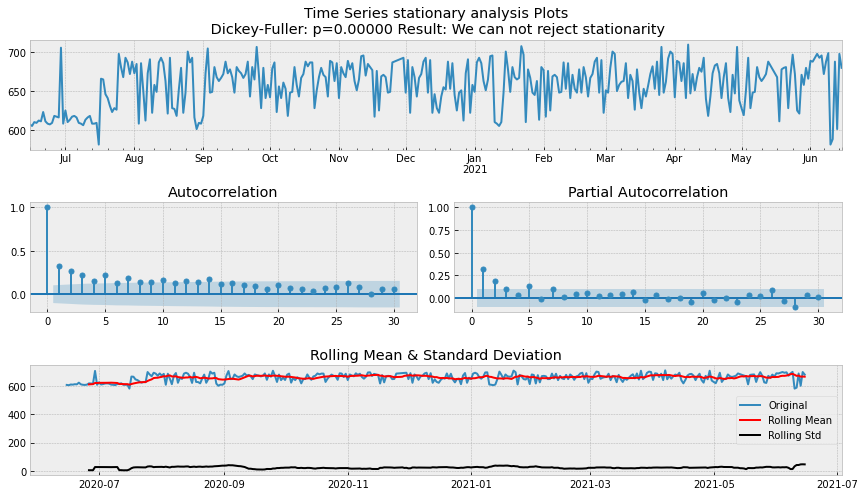

In [32]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=(12, 7))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        mean_std_ax = plt.subplot2grid(layout, (2, 0), colspan=2)
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        hypothesis_result = "We can not reject stationarity" if p_value <= 0.05 else "We reject stationarity"
        ts_ax.set_title(
            'Time Series stationary analysis Plots\n Dickey-Fuller: p={0:.5f} Result: {1}'.format(p_value, hypothesis_result))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

        rolmean = df['Total Beds Available'].rolling(window=12).mean()
        rolstd = df['Total Beds Available'].rolling(window=12).std()

        # Plot rolling statistics:
        orig = plt.plot(df['Total Beds Available'], label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label='Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')


tsplot(df['Total Beds Available'], lags=30)

# MODEL BUILDING

In [33]:
df.shape

(366, 1)

In [34]:
train = df.head(336)
test = df.tail(30)

In [35]:
train.tail()

,Total Beds Available
2021-05-12,672.0
2021-05-13,688.0
2021-05-14,683.0
2021-05-15,678.0
2021-05-16,673.0


In [36]:
train.head()

,Total Beds Available
2020-06-15,607.0
2020-06-16,605.0
2020-06-17,610.0
2020-06-18,609.0
2020-06-19,612.0


In [37]:
test.count()

Total Beds Available    30
dtype: int64

In [38]:

from sklearn.metrics import mean_squared_error
from math import sqrt

In [39]:
def RMSE(pred,org):
    temp = np.sqrt(mean_squared_error(org, pred))
    return np.mean(temp)

Naive Model for Test Data

In [40]:
dd= np.asarray(train['Total Beds Available'])
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]

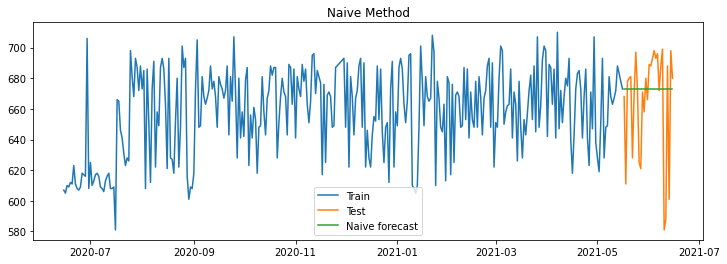

In [41]:
#Plot train, test and forecast
plt.figure(figsize=(12,4))
plt.plot(train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat['naive'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Naive Method')
plt.show()

In [42]:
#RMSE Value
RMSE_Naive_test=RMSE(y_hat['naive'],test['Total Beds Available'])

In [43]:
RMSE_Naive_test

35.14825742479988

Naive Model for Train Data

In [44]:
dd= np.asarray(test['Total Beds Available'])
y_hat = train.copy()
y_hat['naive'] = dd[len(dd)-1]

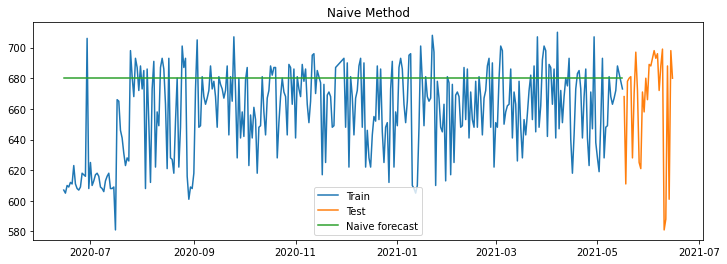

In [45]:
#Plot train, test and forecast
plt.figure(figsize=(12,4))
plt.plot(train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat['naive'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Naive Method')
plt.show()

In [46]:
#RMSE Value
RMSE_Naive_train=RMSE(y_hat['naive'],train['Total Beds Available'])

In [47]:
RMSE_Naive_train

35.62813060597188

Naive Model for Combined Data

In [48]:
df_len =366

In [49]:
y_hat = df.copy()
y_hat['naive'] = df['Total Beds Available'][df_len-1]

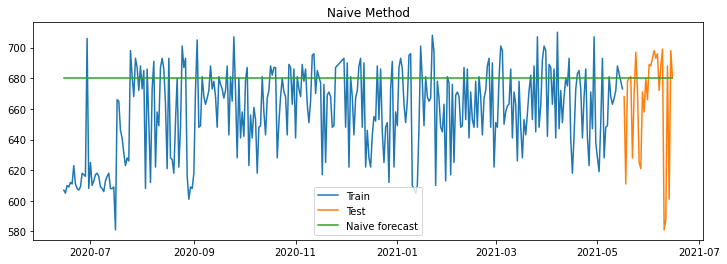

In [50]:
#Plot train, test and forecast
plt.figure(figsize=(12,4))
plt.plot(train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat['naive'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Naive Method')
plt.show()

In [51]:
#RMSE Value
RMSE_Naive_combineddata=RMSE(y_hat['naive'],df['Total Beds Available'])

In [52]:
results = pd.DataFrame({'Method':['Naive method'], 'RMSE_TEST': [RMSE_Naive_test], 'RMSE_TRAIN': [RMSE_Naive_train], 'RMSE_DATA' : [RMSE_Naive_combineddata]})
results = results[['Method', 'RMSE_TEST', 'RMSE_TRAIN','RMSE_DATA']]
results

,Method,RMSE_TEST,RMSE_TRAIN,RMSE_DATA
0,Naive method,35.148257,35.628131,35.769687


Simple Average Method for test Data

In [53]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Total Beds Available'].mean()

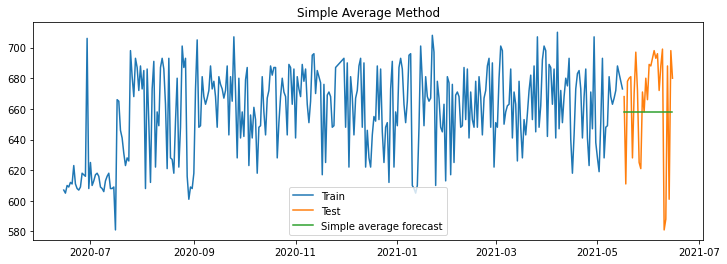

In [54]:
plt.figure(figsize=(12,4))
plt.plot(train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Simple average forecast')
plt.legend(loc='best')
plt.title('Simple Average Method')
plt.show()

In [55]:
#RMSE Value
RMSE_Simpleavg_test=RMSE(y_hat_avg['avg_forecast'],test['Total Beds Available'])

In [56]:
RMSE_Simpleavg_test

35.0479208354712

Simple Average Method for train Data

In [57]:
y_hat_avg = train.copy()
y_hat_avg['avg_forecast'] = test['Total Beds Available'].mean()

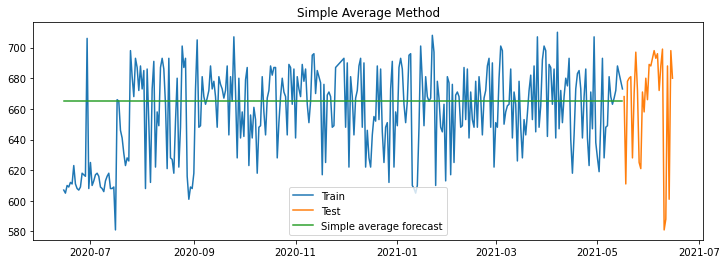

In [58]:
plt.figure(figsize=(12,4))
plt.plot(train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Simple average forecast')
plt.legend(loc='best')
plt.title('Simple Average Method')
plt.show()

In [59]:
#RMSE Value
RMSE_Simpleavg_train=RMSE(y_hat_avg['avg_forecast'],train['Total Beds Available'])

In [60]:
y_hat_avg = df.copy()
y_hat_avg['avg_forecast'] = df['Total Beds Available'].mean()

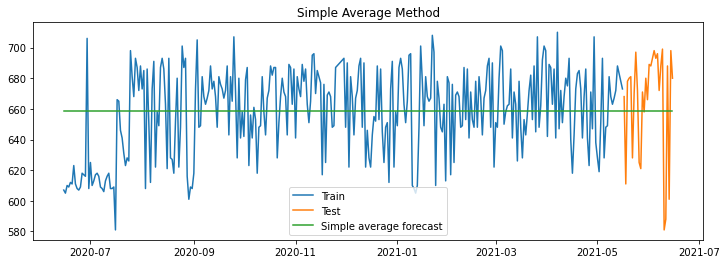

In [61]:
plt.figure(figsize=(12,4))
plt.plot(train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Simple average forecast')
plt.legend(loc='best')
plt.title('Simple Average Method')
plt.show()

In [62]:
#RMSE Value
RMSE_Simpleavg_data=RMSE(y_hat_avg['avg_forecast'],df['Total Beds Available'])

In [63]:
tempResults = pd.DataFrame({'Method':['Simple Average Method'], 'RMSE_TEST': [RMSE_Simpleavg_test], 'RMSE_TRAIN': [RMSE_Simpleavg_train], 'RMSE_DATA' : [RMSE_Simpleavg_data]})
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE_TEST', 'RMSE_TRAIN','RMSE_DATA']]
results

,Method,RMSE_TEST,RMSE_TRAIN,RMSE_DATA
0,Naive method,35.148257,35.628131,35.769687
0,Simple Average Method,35.047921,28.952648,28.660780


MOVING AVERAGE for Test

In [64]:
y_hat_sma = test.copy()
y_hat_sma['moving_avg_forecast'] = train['Total Beds Available'].rolling(12).mean().iloc[-1]

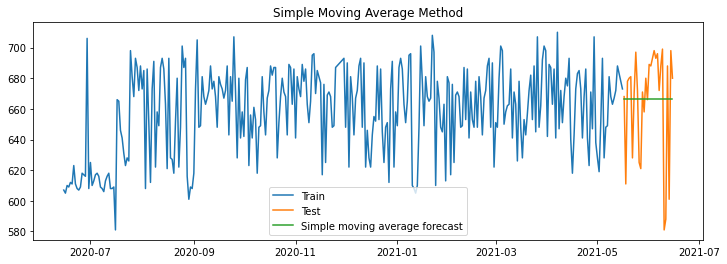

In [65]:
plt.figure(figsize=(12,4))
plt.plot(train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_sma['moving_avg_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

In [66]:
#RMSE Value
RMSE_SimpleMovingAvg_test=RMSE(y_hat_sma['moving_avg_forecast'],test['Total Beds Available'])

In [67]:
RMSE_SimpleMovingAvg_test

34.309133866459916

MOVING AVERAGE for Train data

In [68]:
y_hat_sma = train.copy()
y_hat_sma['moving_avg_forecast'] = test['Total Beds Available'].rolling(12).mean().iloc[-1]

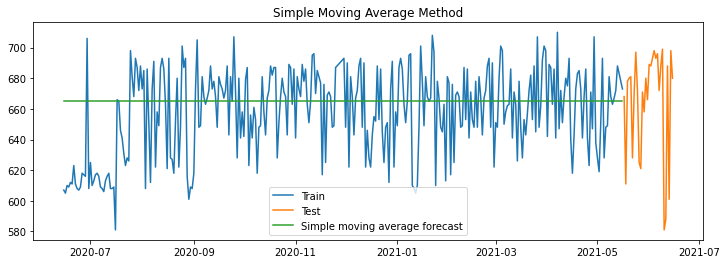

In [69]:
plt.figure(figsize=(12,4))
plt.plot(train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_sma['moving_avg_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

In [70]:
#RMSE Value
RMSE_SimpleMovingAvg_train=RMSE(y_hat_sma['moving_avg_forecast'],train['Total Beds Available'])

MOVING AVERAGE for data

In [71]:
y_hat_sma = df.copy()
y_hat_sma['moving_avg_forecast'] = df['Total Beds Available'].rolling(12).mean().iloc[-1]

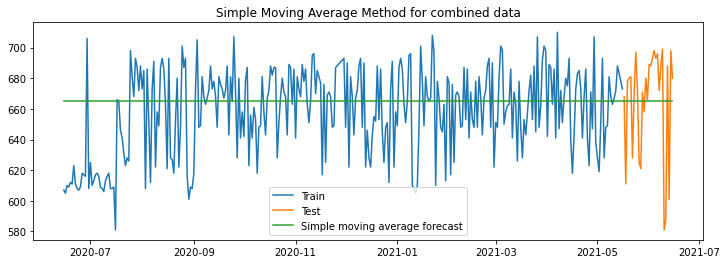

In [72]:
plt.figure(figsize=(12,4))
plt.plot(train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_sma['moving_avg_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method for combined data')
plt.show()

In [73]:
RMSE_SimpleMovingAvg_data=RMSE(y_hat_sma['moving_avg_forecast'],df['Total Beds Available'])

In [74]:
tempResults = pd.DataFrame({'Method':['Simple Moving Average Method'], 'RMSE_TEST': [RMSE_SimpleMovingAvg_test], 'RMSE_TRAIN': [RMSE_SimpleMovingAvg_train], 'RMSE_DATA' : [RMSE_SimpleMovingAvg_data]})
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE_TEST', 'RMSE_TRAIN','RMSE_DATA']]
results

,Method,RMSE_TEST,RMSE_TRAIN,RMSE_DATA
0,Naive method,35.148257,35.628131,35.769687
0,Simple Average Method,35.047921,28.952648,28.660780
0,Simple Moving Average Method,34.309134,28.927722,29.403792


Simple Exponential Smoothing Test Data

In [75]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [76]:
y_hat_ses = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['Total Beds Available'])).fit(smoothing_level=0.6,optimized=False)
y_hat_ses['SES'] = fit2.forecast(len(test))

C:\Users\fast\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


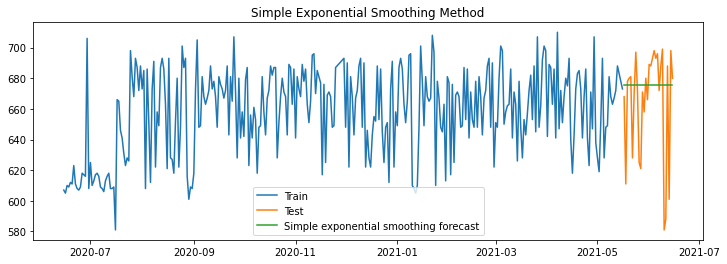

In [77]:
plt.figure(figsize=(12,4))
plt.plot(train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_ses['SES'], label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

In [78]:
#RMSE Value
RMSE_Exponentialsmoothing_test=RMSE(y_hat_ses['SES'],test['Total Beds Available'])

In [79]:
RMSE_Exponentialsmoothing_test

35.82497299189456

Simple Exponential Smoothing Train Data

In [80]:
y_hat_ses = train.copy()
fit2 = SimpleExpSmoothing(np.asarray(test['Total Beds Available'])).fit(smoothing_level=0.6,optimized=False)
y_hat_ses['SES'] = fit2.forecast(len(train))

C:\Users\fast\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


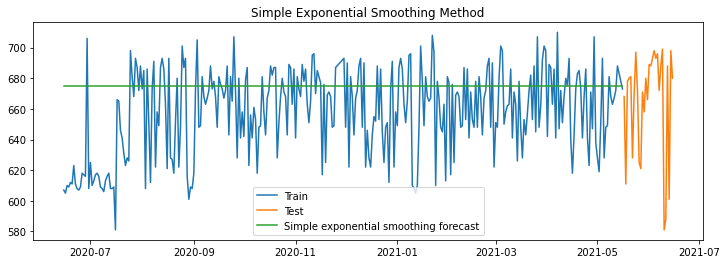

In [81]:
plt.figure(figsize=(12,4))
plt.plot(train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_ses['SES'], label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

In [82]:
#RMSE Value
RMSE_Exponentialsmoothing_train=RMSE(y_hat_ses['SES'],train['Total Beds Available'])

In [83]:
RMSE_Exponentialsmoothing_train

32.818034330769585

Simple Exponential Smoothing Combined Data

In [84]:
y_hat_ses = df.copy()
fit2 = SimpleExpSmoothing(np.asarray(df['Total Beds Available'])).fit(smoothing_level=0.6,optimized=False)
y_hat_ses['SES'] = fit2.forecast(len(df))

C:\Users\fast\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


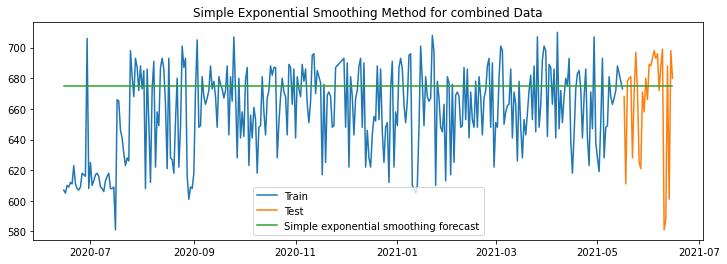

In [85]:
plt.figure(figsize=(12,4))
plt.plot(train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_ses['SES'], label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method for combined Data')
plt.show()

In [86]:
#RMSE Value
RMSE_Exponentialsmoothing_data=RMSE(y_hat_ses['SES'],df['Total Beds Available'])

In [87]:
RMSE_Exponentialsmoothing_data

33.06043116843945

In [88]:
tempResults = pd.DataFrame({'Method':['Simple Exponential Smoothing'], 'RMSE_TEST': [RMSE_Exponentialsmoothing_test], 'RMSE_TRAIN': [RMSE_Exponentialsmoothing_train], 'RMSE_DATA' : [RMSE_Exponentialsmoothing_data]})
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE_TEST', 'RMSE_TRAIN','RMSE_DATA']]
results

,Method,RMSE_TEST,RMSE_TRAIN,RMSE_DATA
0,Naive method,35.148257,35.628131,35.769687
0,Simple Average Method,35.047921,28.952648,28.660780
0,Simple Moving Average Method,34.309134,28.927722,29.403792
0,Simple Exponential Smoothing,35.824973,32.818034,33.060431


Holts Linear Trend method for Test Data

In [89]:
y_hat_holt = test.copy()
fit1 = Holt(np.asarray(train['Total Beds Available'])).fit(smoothing_level = 0.02,smoothing_slope = 0.1)
y_hat_holt['Holt_linear'] = fit1.forecast(len(test))

C:\Users\fast\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
<ipython-input-89-5bd6e32cc32e>:2: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit1 = Holt(np.asarray(train['Total Beds Available'])).fit(smoothing_level = 0.02,smoothing_slope = 0.1)


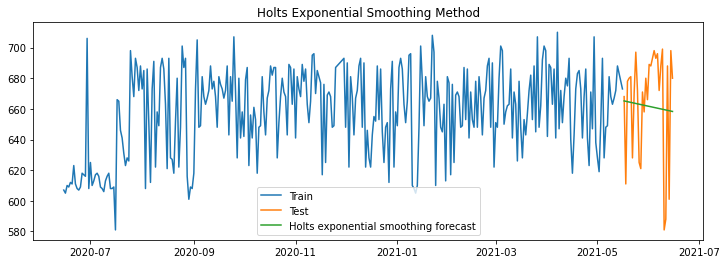

In [90]:
plt.figure(figsize=(12,4))
plt.plot( train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_holt['Holt_linear'], label='Holts exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Holts Exponential Smoothing Method')
plt.show()

In [91]:
#RMSE Value
RMSE_HoltLinear_test= RMSE(y_hat_holt['Holt_linear'],test['Total Beds Available'])

In [92]:
RMSE_HoltLinear_test

34.56342850913107

Holts Linear Trend method for Test Data

In [93]:
y_hat_holt = train.copy()
fit1 = Holt(np.asarray(test['Total Beds Available'])).fit(smoothing_level = 0.02,smoothing_slope = 0.1)
y_hat_holt['Holt_linear'] = fit1.forecast(len(train))

C:\Users\fast\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
<ipython-input-93-aa1368f49f68>:2: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit1 = Holt(np.asarray(test['Total Beds Available'])).fit(smoothing_level = 0.02,smoothing_slope = 0.1)


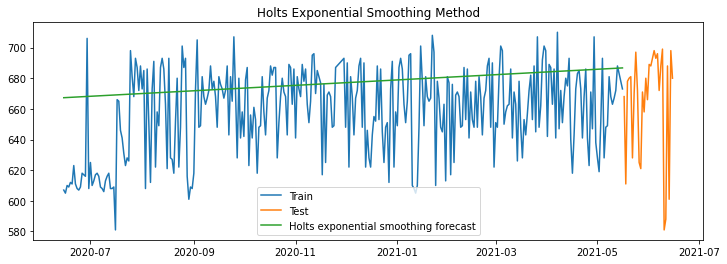

In [94]:
plt.figure(figsize=(12,4))
plt.plot( train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_holt['Holt_linear'], label='Holts exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Holts Exponential Smoothing Method')
plt.show()

In [95]:
#RMSE Value
RMSE_HoltLinear_train= RMSE(y_hat_holt['Holt_linear'],train['Total Beds Available'])

In [96]:
RMSE_HoltLinear_train

32.95129977934067

Holts Linear Trend method for Combined Data

In [97]:
y_hat_holt = df.copy()
fit1 = Holt(np.asarray(df['Total Beds Available'])).fit(smoothing_level = 0.02,smoothing_slope = 0.1)
y_hat_holt['Holt_linear'] = fit1.forecast(len(df))

C:\Users\fast\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
<ipython-input-97-86af7b387fdf>:2: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit1 = Holt(np.asarray(df['Total Beds Available'])).fit(smoothing_level = 0.02,smoothing_slope = 0.1)


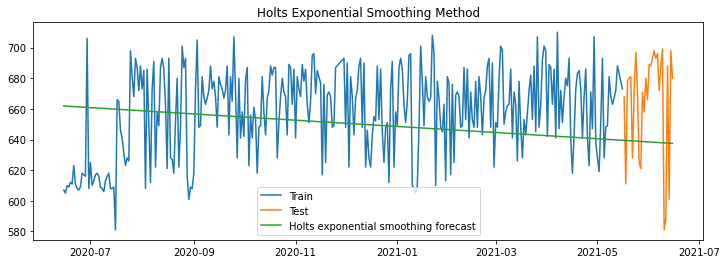

In [98]:
plt.figure(figsize=(12,4))
plt.plot( train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_holt['Holt_linear'], label='Holts exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Holts Exponential Smoothing Method')
plt.show()

In [99]:
#RMSE Value
RMSE_HoltLinear_data= RMSE(y_hat_holt['Holt_linear'],df['Total Beds Available'])

In [100]:
RMSE_HoltLinear_data

32.58424252734103

In [101]:
tempResults = pd.DataFrame({'Method':['Holts Exponential Smoothing Method'], 'RMSE_TEST': [RMSE_HoltLinear_test], 'RMSE_TRAIN': [RMSE_HoltLinear_train], 'RMSE_DATA' : [RMSE_HoltLinear_data]})
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE_TEST', 'RMSE_TRAIN','RMSE_DATA']]
results

,Method,RMSE_TEST,RMSE_TRAIN,RMSE_DATA
0,Naive method,35.148257,35.628131,35.769687
0,Simple Average Method,35.047921,28.952648,28.660780
0,Simple Moving Average Method,34.309134,28.927722,29.403792
0,Simple Exponential Smoothing,35.824973,32.818034,33.060431
0,Holts Exponential Smoothing Method,34.563429,32.951300,32.584243


Holt's Winter Exponential Smoothing with Additive seasonality and Additive trend for Test Data

In [102]:
y_hat_hwa = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Total Beds Available']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_hwa['Holt_Winter'] = fit1.forecast(len(test))

C:\Users\fast\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


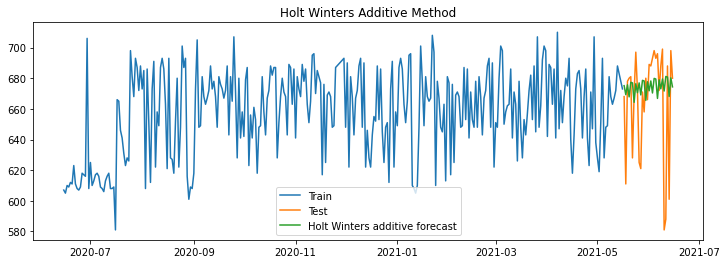

In [103]:
plt.figure(figsize=(12,4))
plt.plot( train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_hwa['Holt_Winter'], label='Holt Winters additive forecast')
plt.legend(loc='best')
plt.title('Holt Winters Additive Method')
plt.show()

In [104]:
#RMSE Value
RMSE_HoltWinterAdd_test=RMSE(y_hat_hwa['Holt_Winter'],test['Total Beds Available'])

In [105]:
RMSE_HoltWinterAdd_test

35.11867728243179

Holt's Winter Exponential Smoothing with Additive seasonality and Additive trend for Train Data

In [106]:
y_hat_hwa = train.copy()
fit1 = ExponentialSmoothing(np.asarray(test['Total Beds Available']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_hwa['Holt_Winter'] = fit1.forecast(len(train))

C:\Users\fast\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


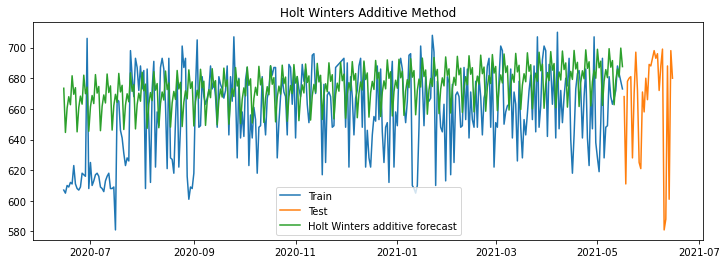

In [107]:
plt.figure(figsize=(12,4))
plt.plot( train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_hwa['Holt_Winter'], label='Holt Winters additive forecast')
plt.legend(loc='best')
plt.title('Holt Winters Additive Method')
plt.show()

In [108]:
#RMSE Value
RMSE_HoltWinterAdd_train=RMSE(y_hat_hwa['Holt_Winter'],train['Total Beds Available'])

In [109]:
RMSE_HoltWinterAdd_train

32.82476531670612

Holt's Winter Exponential Smoothing with Additive seasonality and Additive trend for CombinedData

In [110]:
y_hat_hwa = df.copy()
fit1 = ExponentialSmoothing(np.asarray(df['Total Beds Available']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_hwa['Holt_Winter'] = fit1.forecast(len(df))

C:\Users\fast\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


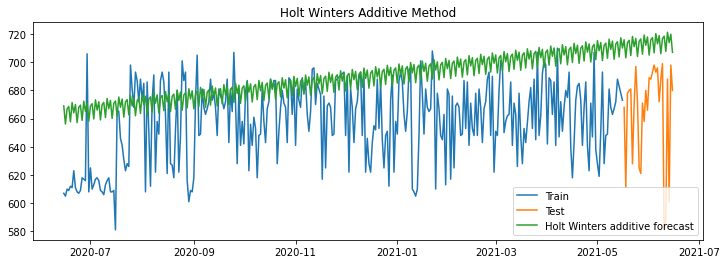

In [111]:
plt.figure(figsize=(12,4))
plt.plot( train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_hwa['Holt_Winter'], label='Holt Winters additive forecast')
plt.legend(loc='best')
plt.title('Holt Winters Additive Method')
plt.show()

In [112]:
#RMSE Value
RMSE_HoltWinterAdd_data=RMSE(y_hat_hwa['Holt_Winter'],df['Total Beds Available'])

In [113]:
RMSE_HoltWinterAdd_data

42.45772913093637

In [114]:
tempResults = pd.DataFrame({'Method':['Holt Winters Additive Method'], 'RMSE_TEST': [RMSE_HoltWinterAdd_test], 'RMSE_TRAIN': [RMSE_HoltWinterAdd_train], 'RMSE_DATA' : [RMSE_HoltWinterAdd_data]})
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE_TEST', 'RMSE_TRAIN','RMSE_DATA']]
results

,Method,RMSE_TEST,RMSE_TRAIN,RMSE_DATA
0,Naive method,35.148257,35.628131,35.769687
0,Simple Average Method,35.047921,28.952648,28.660780
0,Simple Moving Average Method,34.309134,28.927722,29.403792
0,Simple Exponential Smoothing,35.824973,32.818034,33.060431
0,Holts Exponential Smoothing Method,34.563429,32.951300,32.584243
0,Holt Winters Additive Method,35.118677,32.824765,42.457729


Holts winter exponential smoothing with multiplicative seasonality and additive trend for test data

In [115]:
y_hat_hwm = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Total Beds Available']) ,seasonal_periods=7 ,trend='add', seasonal='mul',).fit()
y_hat_hwm['Holt_Winter'] = fit1.forecast(len(test))

C:\Users\fast\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


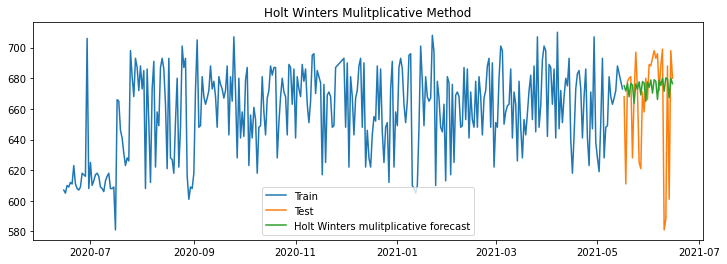

In [116]:
plt.figure(figsize=(12,4))
plt.plot( train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_hwm['Holt_Winter'], label='Holt Winters mulitplicative forecast')
plt.legend(loc='best')
plt.title('Holt Winters Mulitplicative Method')
plt.show()

In [117]:
#RMSE Value
RMSE_HoltwinterMult_test=RMSE(y_hat_hwm['Holt_Winter'],test['Total Beds Available'])

In [118]:
RMSE_HoltwinterMult_test

35.04374034743399

Holts winter exponential smoothing with multiplicative seasonality and additive trend for train data

In [119]:
y_hat_hwm = train.copy()
fit1 = ExponentialSmoothing(np.asarray(test['Total Beds Available']) ,seasonal_periods=7 ,trend='add', seasonal='mul',).fit()
y_hat_hwm['Holt_Winter'] = fit1.forecast(len(train))

C:\Users\fast\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


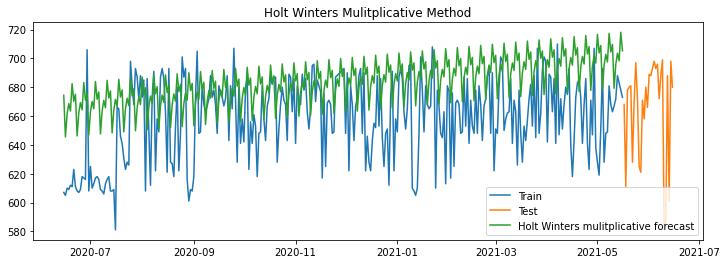

In [120]:
plt.figure(figsize=(12,4))
plt.plot( train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_hwm['Holt_Winter'], label='Holt Winters mulitplicative forecast')
plt.legend(loc='best')
plt.title('Holt Winters Mulitplicative Method')
plt.show()

In [121]:
#RMSE Value
RMSE_HoltwinterMult_train=RMSE(y_hat_hwm['Holt_Winter'],train['Total Beds Available'])

In [122]:
RMSE_HoltwinterMult_train

38.38142160525666

Holts winter exponential smoothing with multiplicative seasonality and additive trend for Combined data

In [123]:
y_hat_hwm = df.copy()
fit1 = ExponentialSmoothing(np.asarray(df['Total Beds Available']) ,seasonal_periods=7 ,trend='add', seasonal='mul',).fit()
y_hat_hwm['Holt_Winter'] = fit1.forecast(len(df))

C:\Users\fast\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


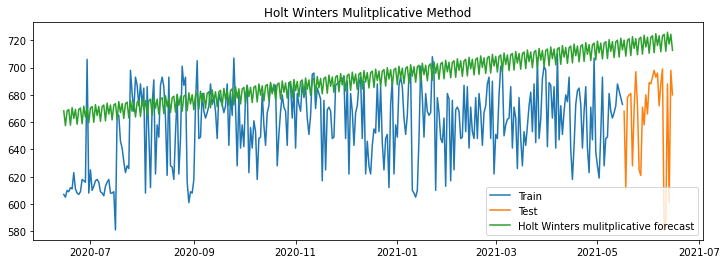

In [124]:
plt.figure(figsize=(12,4))
plt.plot( train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_hwm['Holt_Winter'], label='Holt Winters mulitplicative forecast')
plt.legend(loc='best')
plt.title('Holt Winters Mulitplicative Method')
plt.show()

In [125]:
#RMSE Value
RMSE_HoltwinterMult_data=RMSE(y_hat_hwm['Holt_Winter'],df['Total Beds Available'])

In [126]:
RMSE_HoltwinterMult_data

44.579333890045625

In [127]:
tempResults = pd.DataFrame({'Method':['Holt Winters Mulitplicative Method'], 'RMSE_TEST': [RMSE_HoltwinterMult_test], 'RMSE_TRAIN': [RMSE_HoltwinterMult_train], 'RMSE_DATA' : [RMSE_HoltwinterMult_data]})
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE_TEST', 'RMSE_TRAIN','RMSE_DATA']]
results

,Method,RMSE_TEST,RMSE_TRAIN,RMSE_DATA
0,Naive method,35.148257,35.628131,35.769687
0,Simple Average Method,35.047921,28.952648,28.660780
0,Simple Moving Average Method,34.309134,28.927722,29.403792
0,Simple Exponential Smoothing,35.824973,32.818034,33.060431
0,Holts Exponential Smoothing Method,34.563429,32.951300,32.584243
0,Holt Winters Additive Method,35.118677,32.824765,42.457729
0,Holt Winters Mulitplicative Method,35.043740,38.381422,44.579334


AR Model for Test data

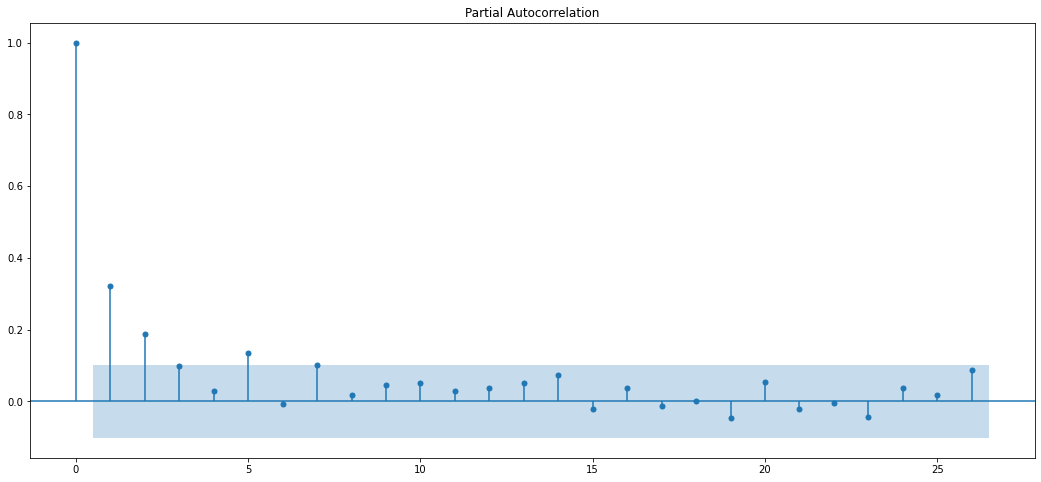

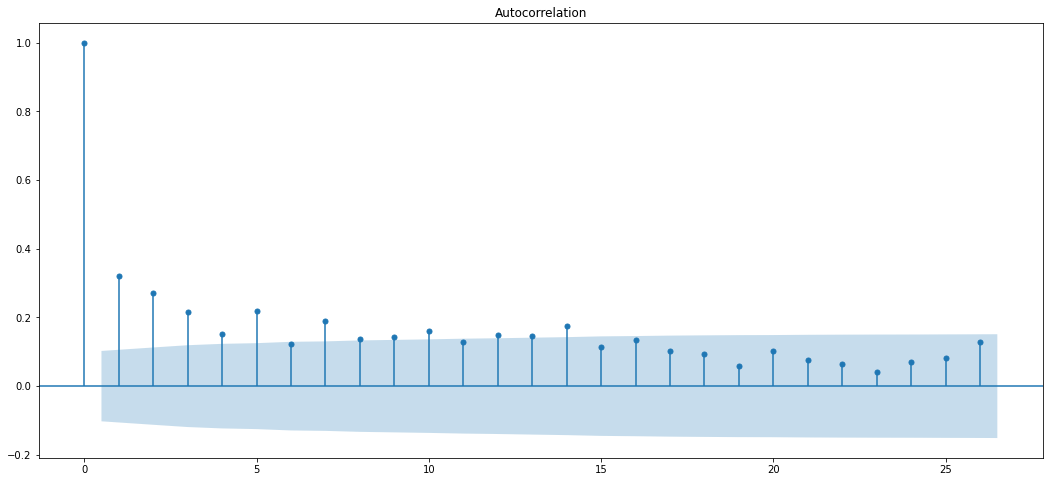

In [128]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
pacf = plot_pacf(df['Total Beds Available'])
acf = plot_acf(df['Total Beds Available'])

In [129]:
from statsmodels.tsa.ar_model import AutoReg

In [130]:
AR_model = AutoReg(train, lags=3).fit()

C:\Users\fast\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [131]:
print(AR_model.summary())

                             AutoReg Model Results                              
Dep. Variable:     Total Beds Available   No. Observations:                  336
Model:                       AutoReg(3)   Log Likelihood               -1550.026
Method:                 Conditional MLE   S.D. of innovations             25.427
Date:                  Tue, 14 Sep 2021   AIC                              6.502
Time:                          12:38:35   BIC                              6.559
Sample:                      06-18-2020   HQIC                             6.524
                           - 05-16-2021                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
intercept                 316.5166     44.065      7.183      0.000     230.152     402.881
Total Beds Available.L1     0.2393      0.054      4.392      0.000       0.

In [132]:
y_hat_ar = AR_model.predict(start = test.index[0],end = test.index[-1],dynamic= False)

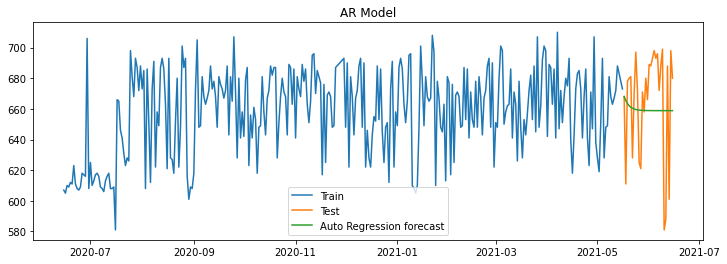

In [133]:
plt.figure(figsize=(12,4))
plt.plot( train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_ar, label='Auto Regression forecast')
plt.legend(loc='best')
plt.title('AR Model')
plt.show()

In [134]:
#RMSE Value
RMSE_AR_test= RMSE(y_hat_ar,test['Total Beds Available'])

In [135]:
RMSE_AR_test

35.00477574116403

AR Model for Train data

In [136]:
AR_model = AutoReg(df, lags=3).fit()

C:\Users\fast\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [137]:
print(AR_model.summary())

                             AutoReg Model Results                              
Dep. Variable:     Total Beds Available   No. Observations:                  366
Model:                       AutoReg(3)   Log Likelihood               -1702.956
Method:                 Conditional MLE   S.D. of innovations             26.375
Date:                  Tue, 14 Sep 2021   AIC                              6.572
Time:                          12:38:36   BIC                              6.626
Sample:                      06-18-2020   HQIC                             6.594
                           - 06-15-2021                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
intercept                 334.8555     43.575      7.685      0.000     249.450     420.261
Total Beds Available.L1     0.2307      0.052      4.420      0.000       0.

In [138]:
y_hat_ar = AR_model.predict(start = train.index[0],end = train.index[-1],dynamic= False)

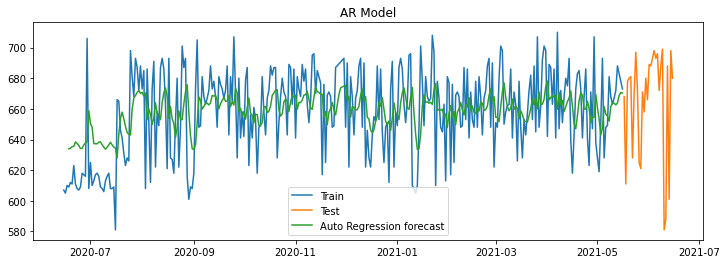

In [139]:
plt.figure(figsize=(12,4))
plt.plot( train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_ar, label='Auto Regression forecast')
plt.legend(loc='best')
plt.title('AR Model')
plt.show()

AR Model for COMBINED Data

In [140]:
AR_model = AutoReg(df, lags=3).fit()

C:\Users\fast\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [141]:
print(AR_model.summary())

                             AutoReg Model Results                              
Dep. Variable:     Total Beds Available   No. Observations:                  366
Model:                       AutoReg(3)   Log Likelihood               -1702.956
Method:                 Conditional MLE   S.D. of innovations             26.375
Date:                  Tue, 14 Sep 2021   AIC                              6.572
Time:                          12:38:38   BIC                              6.626
Sample:                      06-18-2020   HQIC                             6.594
                           - 06-15-2021                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
intercept                 334.8555     43.575      7.685      0.000     249.450     420.261
Total Beds Available.L1     0.2307      0.052      4.420      0.000       0.

In [142]:
y_hat_ar = AR_model.predict(start =df.index[0],end = df.index[-1],dynamic= False)

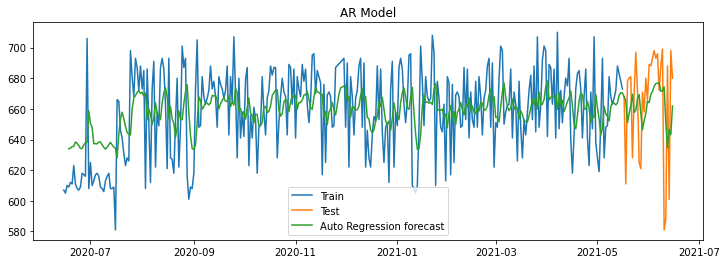

In [143]:
plt.figure(figsize=(12,4))
plt.plot( train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_ar, label='Auto Regression forecast')
plt.legend(loc='best')
plt.title('AR Model')
plt.show()

MA Model for test Data

In [144]:
from statsmodels.tsa.arima_model import ARMA
from random import random

In [145]:
# fit model
MA_model = ARMA(train, order=(0, 5)).fit()

C:\Users\fast\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [146]:
print(MA_model.summary())

                               ARMA Model Results                               
Dep. Variable:     Total Beds Available   No. Observations:                  336
Model:                       ARMA(0, 5)   Log Likelihood               -1565.593
Method:                         css-mle   S.D. of innovations             25.539
Date:                  Tue, 14 Sep 2021   AIC                           3145.186
Time:                          12:38:42   BIC                           3171.906
Sample:                      06-15-2020   HQIC                          3155.837
                           - 05-16-2021                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        657.8861      2.562    256.750      0.000     652.864     662.908
ma.L1.Total Beds Available     0.2665      0.055      4.839      0.

In [147]:
y_hat_ma = MA_model.predict(start = test.index[0],end = test.index[-1],dynamic= False)

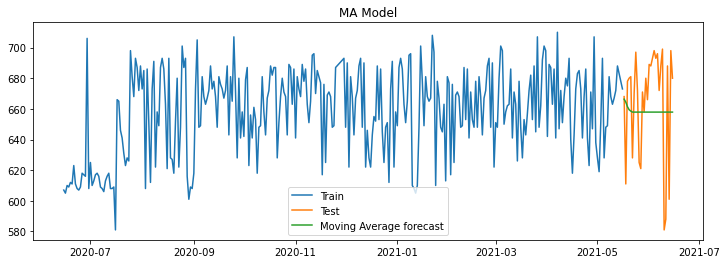

In [148]:
plt.figure(figsize=(12,4))
plt.plot( train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_ma, label='Moving Average forecast')
plt.legend(loc='best')
plt.title('MA Model')
plt.show()

In [149]:
#RMSE Value
RMSE_MA_test=RMSE(y_hat_ma,test['Total Beds Available'])

In [150]:
RMSE_MA_test

35.2275636220049

MA Model for train Data

In [151]:
# fit model
MA_model = ARMA(df, order=(0, 5)).fit()

C:\Users\fast\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [152]:
print(MA_model.summary())

                               ARMA Model Results                               
Dep. Variable:     Total Beds Available   No. Observations:                  366
Model:                       ARMA(0, 5)   Log Likelihood               -1718.182
Method:                         css-mle   S.D. of innovations             26.449
Date:                  Tue, 14 Sep 2021   AIC                           3450.363
Time:                          12:38:43   BIC                           3477.682
Sample:                      06-15-2020   HQIC                          3461.219
                           - 06-15-2021                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        658.5297      2.488    264.724      0.000     653.654     663.405
ma.L1.Total Beds Available     0.2544      0.053      4.829      0.

In [153]:
y_hat_ma = MA_model.predict(start = train.index[0],end = train.index[-1],dynamic= False)

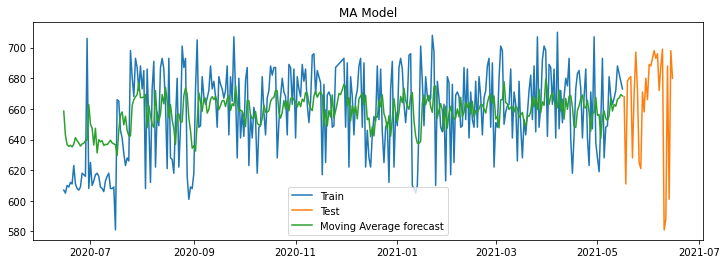

In [154]:
plt.figure(figsize=(12,4))
plt.plot( train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_ma, label='Moving Average forecast')
plt.legend(loc='best')
plt.title('MA Model')
plt.show()

In [155]:
#RMSE Value
RMSE_MA_train=RMSE(y_hat_ma,train['Total Beds Available'])

In [156]:
RMSE_MA_train

25.579504326742974

MA Model for combined Data

In [157]:
# fit model
MA_model = ARMA(df, order=(0, 5)).fit()

C:\Users\fast\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [158]:
print(MA_model.summary())

                               ARMA Model Results                               
Dep. Variable:     Total Beds Available   No. Observations:                  366
Model:                       ARMA(0, 5)   Log Likelihood               -1718.182
Method:                         css-mle   S.D. of innovations             26.449
Date:                  Tue, 14 Sep 2021   AIC                           3450.363
Time:                          12:38:45   BIC                           3477.682
Sample:                      06-15-2020   HQIC                          3461.219
                           - 06-15-2021                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        658.5297      2.488    264.724      0.000     653.654     663.405
ma.L1.Total Beds Available     0.2544      0.053      4.829      0.

In [159]:
y_hat_ma = MA_model.predict(start = df.index[0],end = df.index[-1],dynamic= False)

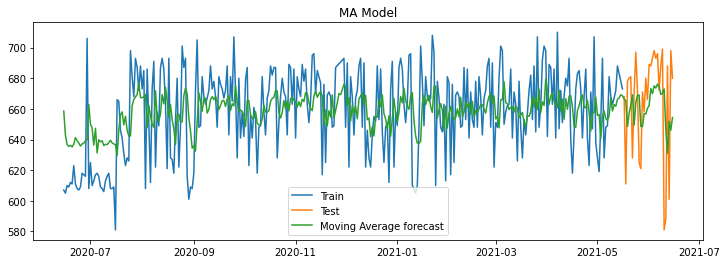

In [160]:
plt.figure(figsize=(12,4))
plt.plot( train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_ma, label='Moving Average forecast')
plt.legend(loc='best')
plt.title('MA Model')
plt.show()

In [161]:
#RMSE Value
RMSE_MA_data=RMSE(y_hat_ma,df['Total Beds Available'])

In [162]:
RMSE_MA_data

26.471891156820917

In [163]:
tempResults = pd.DataFrame({'Method':['Moving Average forecast'], 'RMSE_TEST': [RMSE_MA_test], 'RMSE_TRAIN': [RMSE_MA_train], 'RMSE_DATA' : [RMSE_MA_data]})
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE_TEST', 'RMSE_TRAIN','RMSE_DATA']]
results

,Method,RMSE_TEST,RMSE_TRAIN,RMSE_DATA
0,Naive method,35.148257,35.628131,35.769687
0,Simple Average Method,35.047921,28.952648,28.660780
0,Simple Moving Average Method,34.309134,28.927722,29.403792
0,Simple Exponential Smoothing,35.824973,32.818034,33.060431
0,Holts Exponential Smoothing Method,34.563429,32.951300,32.584243
0,Holt Winters Additive Method,35.118677,32.824765,42.457729
0,Holt Winters Mulitplicative Method,35.043740,38.381422,44.579334
0,Moving Average forecast,35.227564,25.579504,26.471891


ARMA Model for Test data

In [164]:
from statsmodels.tsa.arima_model import ARIMA

In [165]:
ARMA_model = ARIMA(train['Total Beds Available'],order=(1,0,1)).fit()

C:\Users\fast\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [166]:
print(ARMA_model.summary())

                               ARMA Model Results                               
Dep. Variable:     Total Beds Available   No. Observations:                  336
Model:                       ARMA(1, 1)   Log Likelihood               -1560.891
Method:                         css-mle   S.D. of innovations             25.169
Date:                  Tue, 14 Sep 2021   AIC                           3129.782
Time:                          12:38:47   BIC                           3145.050
Sample:                      06-15-2020   HQIC                          3135.868
                           - 05-16-2021                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        656.2203      6.633     98.926      0.000     643.219     669.222
ar.L1.Total Beds Available     0.9609      0.034     28.240      0.

In [167]:
y_hat_arma = ARMA_model.predict(start = test.index[0],end = test.index[-1],typ='levels')
print(y_hat_arma)

2021-05-17    669.090908
2021-05-18    668.587478
2021-05-19    668.103740
2021-05-20    667.638924
2021-05-21    667.192288
2021-05-22    666.763122
2021-05-23    666.350743
2021-05-24    665.954494
2021-05-25    665.573744
2021-05-26    665.207887
2021-05-27    664.856341
2021-05-28    664.518545
2021-05-29    664.193961
2021-05-30    663.882074
2021-05-31    663.582386
2021-06-01    663.294420
2021-06-02    663.017718
2021-06-03    662.751839
2021-06-04    662.496360
2021-06-05    662.250873
2021-06-06    662.014989
2021-06-07    661.788331
2021-06-08    661.570539
2021-06-09    661.361266
2021-06-10    661.160178
2021-06-11    660.966956
2021-06-12    660.781292
2021-06-13    660.602890
2021-06-14    660.431466
2021-06-15    660.266747
Freq: D, dtype: float64


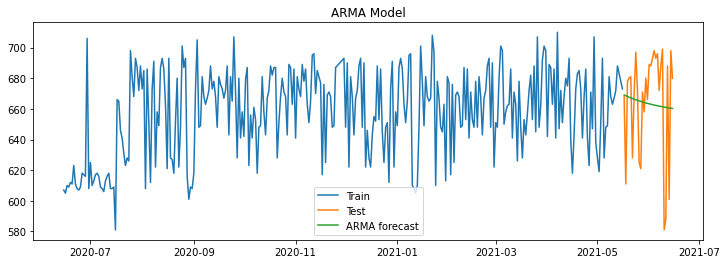

In [168]:
plt.figure(figsize=(12,4))
plt.plot( train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_arma, label='ARMA forecast')
plt.legend(loc='best')
plt.title('ARMA Model')
plt.show()

In [169]:
#RMSE Value
RMSE_ARMA_test=RMSE(y_hat_arma,test['Total Beds Available'])

In [170]:
RMSE_ARMA_test

34.53996160474378

ARMA Model for Train data

In [171]:
ARMA_model = ARIMA(df['Total Beds Available'],order=(1,0,1)).fit()
print(ARMA_model.summary())

C:\Users\fast\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                               ARMA Model Results                               
Dep. Variable:     Total Beds Available   No. Observations:                  366
Model:                       ARMA(1, 1)   Log Likelihood               -1747.444
Method:                         css-mle   S.D. of innovations             28.658
Date:                  Tue, 14 Sep 2021   AIC                           3502.888
Time:                          12:38:49   BIC                           3518.498
Sample:                      06-15-2020   HQIC                          3509.091
                           - 06-15-2021                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        658.6006      1.464    449.816      0.000     655.731     661.470
ar.L1.Total Beds Available     0.9997      0.002    582.801      0.

In [172]:
y_hat_arma = ARMA_model.predict(start = train.index[0],end = train.index[-1],typ='levels')
print(y_hat_arma)

2020-06-15    658.600590
2020-06-16    658.607172
2020-06-17    658.614010
2020-06-18    658.620209
2020-06-19    658.626537
2020-06-20    658.632481
2020-06-21    658.638553
2020-06-22    658.643093
2020-06-23    658.649165
2020-06-24    658.655620
2020-06-25    658.662203
2020-06-26    658.668531
2020-06-27    658.673708
2020-06-28    658.679014
2020-06-29    658.684447
2020-06-30    658.678379
2020-07-01    658.684837
2020-07-02    658.689121
2020-07-03    658.695323
2020-07-04    658.701141
2020-07-05    658.706448
2020-07-06    658.711626
2020-07-07    658.717061
2020-07-08    658.723391
2020-07-09    658.729849
2020-07-10    658.736563
2020-07-11    658.742382
2020-07-12    658.747816
2020-07-13    658.752994
2020-07-14    658.759452
2020-07-15    658.765911
2020-07-16    658.772241
2020-07-17    658.782158
2020-07-18    658.781187
2020-07-19    658.780344
2020-07-20    658.781935
2020-07-21    658.784168
2020-07-22    658.787681
2020-07-23    658.792220
2020-07-24    658.796118


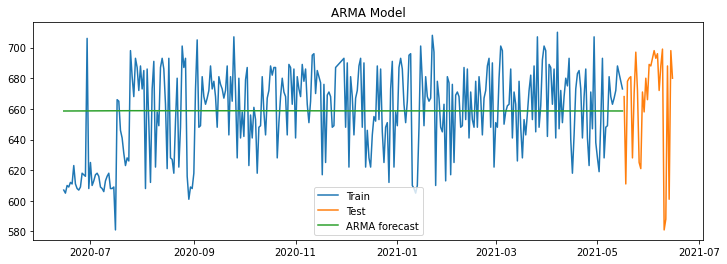

In [173]:
plt.figure(figsize=(12,4))
plt.plot( train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_arma, label='ARMA forecast')
plt.legend(loc='best')
plt.title('ARMA Model')
plt.show()

In [174]:
#RMSE Value
RMSE_ARMA_train=RMSE(y_hat_arma,train['Total Beds Available'])

In [175]:
RMSE_ARMA_train

28.032394747809995

ARMA Model for Combined data

In [176]:
ARMA_model = ARIMA(df['Total Beds Available'],order=(1,0,1)).fit()
print(ARMA_model.summary())

C:\Users\fast\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                               ARMA Model Results                               
Dep. Variable:     Total Beds Available   No. Observations:                  366
Model:                       ARMA(1, 1)   Log Likelihood               -1747.444
Method:                         css-mle   S.D. of innovations             28.658
Date:                  Tue, 14 Sep 2021   AIC                           3502.888
Time:                          12:38:51   BIC                           3518.498
Sample:                      06-15-2020   HQIC                          3509.091
                           - 06-15-2021                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        658.6006      1.464    449.816      0.000     655.731     661.470
ar.L1.Total Beds Available     0.9997      0.002    582.801      0.

In [177]:
y_hat_arma = ARMA_model.predict(start = df.index[0],end = df.index[-1],typ='levels')
print(y_hat_arma)

2020-06-15    658.600590
2020-06-16    658.607172
2020-06-17    658.614010
2020-06-18    658.620209
2020-06-19    658.626537
2020-06-20    658.632481
2020-06-21    658.638553
2020-06-22    658.643093
2020-06-23    658.649165
2020-06-24    658.655620
2020-06-25    658.662203
2020-06-26    658.668531
2020-06-27    658.673708
2020-06-28    658.679014
2020-06-29    658.684447
2020-06-30    658.678379
2020-07-01    658.684837
2020-07-02    658.689121
2020-07-03    658.695323
2020-07-04    658.701141
2020-07-05    658.706448
2020-07-06    658.711626
2020-07-07    658.717061
2020-07-08    658.723391
2020-07-09    658.729849
2020-07-10    658.736563
2020-07-11    658.742382
2020-07-12    658.747816
2020-07-13    658.752994
2020-07-14    658.759452
2020-07-15    658.765911
2020-07-16    658.772241
2020-07-17    658.782158
2020-07-18    658.781187
2020-07-19    658.780344
2020-07-20    658.781935
2020-07-21    658.784168
2020-07-22    658.787681
2020-07-23    658.792220
2020-07-24    658.796118


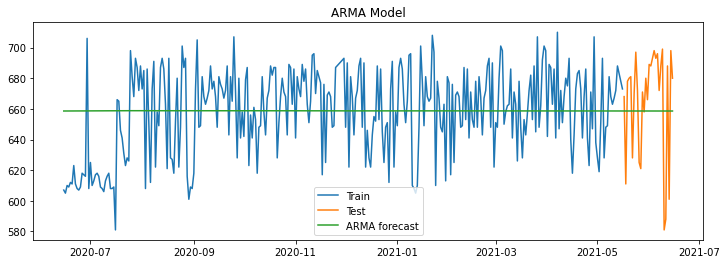

In [178]:
plt.figure(figsize=(12,4))
plt.plot( train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_arma, label='ARMA forecast')
plt.legend(loc='best')
plt.title('ARMA Model')
plt.show()

In [179]:
#RMSE Value
RMSE_ARMA_data=RMSE(y_hat_arma,df['Total Beds Available'])

In [180]:
RMSE_ARMA_data

28.659886753837124

In [181]:
tempResults = pd.DataFrame({'Method':['ARMA forecast'], 'RMSE_TEST': [RMSE_ARMA_test], 'RMSE_TRAIN': [RMSE_ARMA_train], 'RMSE_DATA' : [RMSE_ARMA_data]})
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE_TEST', 'RMSE_TRAIN','RMSE_DATA']]
results

,Method,RMSE_TEST,RMSE_TRAIN,RMSE_DATA
0,Naive method,35.148257,35.628131,35.769687
0,Simple Average Method,35.047921,28.952648,28.660780
0,Simple Moving Average Method,34.309134,28.927722,29.403792
0,Simple Exponential Smoothing,35.824973,32.818034,33.060431
0,Holts Exponential Smoothing Method,34.563429,32.951300,32.584243
0,Holt Winters Additive Method,35.118677,32.824765,42.457729
0,Holt Winters Mulitplicative Method,35.043740,38.381422,44.579334
0,Moving Average forecast,35.227564,25.579504,26.471891
0,ARMA forecast,34.539962,28.032395,28.659887


ARIMA Model for Test Data

In [182]:
from pmdarima import auto_arima
warnings.filterwarnings("ignore")

In [183]:
stepwise_fit= auto_arima(df['Total Beds Available'], trace= True,
                         suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3599.065, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3511.505, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3429.062, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3597.078, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3425.190, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3425.161, Time=0.59 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3486.055, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3427.104, Time=0.57 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3429.714, Time=0.67 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3478.249, Time=0.28 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3426.401, Time=1.41 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3424.664, Time=0.34 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3424.512, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  366
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1709.256
Date:                Tue, 14 Sep 2021   AIC                           3424.512
Time:                        12:39:07   BIC                           3436.211
Sample:                             0   HQIC                          3429.161
                                - 366                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1384      0.048      2.885      0.004       0.044       0.232
ma.L1         -0.9226      0.019    -47.540      0.000      -0.961      -0.885
sigma2       680.8596     47.947     14.200      0.000     586.885     774.834
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                12.75
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -0.40
Prob(H) (two-sided):                  0.99   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [184]:
from statsmodels.tsa.arima_model import ARIMA

In [185]:
ARIMA_model = ARIMA(train['Total Beds Available'],order=(1,1,1)).fit()

In [186]:
print(ARIMA_model.summary())

                               ARIMA Model Results                                
Dep. Variable:     D.Total Beds Available   No. Observations:                  335
Model:                     ARIMA(1, 1, 1)   Log Likelihood               -1555.301
Method:                           css-mle   S.D. of innovations             25.062
Date:                    Tue, 14 Sep 2021   AIC                           3118.602
Time:                            12:39:07   BIC                           3133.858
Sample:                        06-16-2020   HQIC                          3124.684
                             - 05-16-2021                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.1594      0.135      1.180      0.238      -0.105       0.424
ar.L1.D.Total Beds Available     0.1337      

In [187]:
y_hat_arima = ARIMA_model.predict(start = test.index[0],end = test.index[-1],typ='levels')
print(y_hat_arima)

2021-05-17    668.789569
2021-05-18    668.364812
2021-05-19    668.446147
2021-05-20    668.595140
2021-05-21    668.753178
2021-05-22    668.912425
2021-05-23    669.071834
2021-05-24    669.231264
2021-05-25    669.390698
2021-05-26    669.550131
2021-05-27    669.709565
2021-05-28    669.868999
2021-05-29    670.028432
2021-05-30    670.187866
2021-05-31    670.347300
2021-06-01    670.506733
2021-06-02    670.666167
2021-06-03    670.825601
2021-06-04    670.985035
2021-06-05    671.144468
2021-06-06    671.303902
2021-06-07    671.463336
2021-06-08    671.622769
2021-06-09    671.782203
2021-06-10    671.941637
2021-06-11    672.101071
2021-06-12    672.260504
2021-06-13    672.419938
2021-06-14    672.579372
2021-06-15    672.738805
Freq: D, dtype: float64


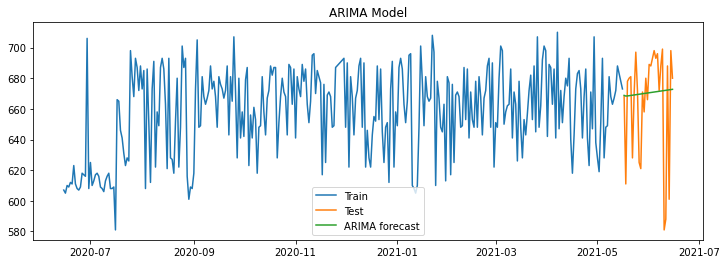

In [188]:
plt.figure(figsize=(12,4))
plt.plot( train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_arima, label='ARIMA forecast')
plt.legend(loc='best')
plt.title('ARIMA Model')
plt.show()

In [189]:
#RMSE Value
RMSE_ARIMA_test=RMSE(y_hat_arima,test['Total Beds Available'])

In [190]:
RMSE_ARIMA_test

34.68209992390091

In [191]:
ARIMA_model = ARIMA(df['Total Beds Available'],order=(1,1,1)).fit()

SARIMA for Test Data

In [192]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [193]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

In [194]:
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [195]:
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [196]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None
for param in pdq:   
    for param_seasonal in seasonal_pdq: 
        temp_model = SARIMAX(train,order=param,seasonal_order = param_seasonal,enforce_invertibility=False,
                             enforce_stationarity=False)
        results = temp_model.fit(disp=False)
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            best_seasonal_pdq = param_seasonal
print("Best ARIMA {} x {} model - AIC:{}".format(best_pdq,best_seasonal_pdq,best_aic))

Best ARIMA (1, 1, 1) x (0, 1, 1, 12) model - AIC:2913.7157754861923


In [197]:
SARIMA_model = SARIMAX(train,order=(0,1,1),seasonal_order=(0,1,1,12),enforce_invertibility=False,
                             enforce_stationarity=False).fit()

In [198]:
y_hat_sarima = SARIMA_model.predict(start = test.index[0],end = test.index[-1], dynamic=False)

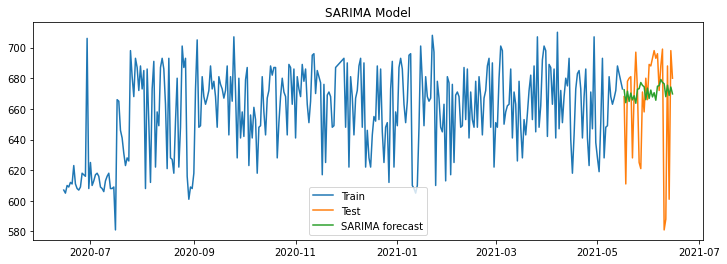

In [199]:
plt.figure(figsize=(12,4))
plt.plot( train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_sarima, label='SARIMA forecast')
plt.legend(loc='best')
plt.title('SARIMA Model')
plt.show()

In [200]:
#RMSE Value
RMSE_SARIMA_test=RMSE(y_hat_sarima,test['Total Beds Available'])

In [201]:
RMSE_SARIMA_test

34.92042535655868

SARIMA for Train Data

In [202]:
SARIMA_model = SARIMAX(df,order=(0,1,1),seasonal_order=(0,1,1,12),enforce_invertibility=False,
                             enforce_stationarity=False).fit()

In [203]:
y_hat_sarima = SARIMA_model.predict(start = train.index[0],end = train.index[-1], dynamic=False)

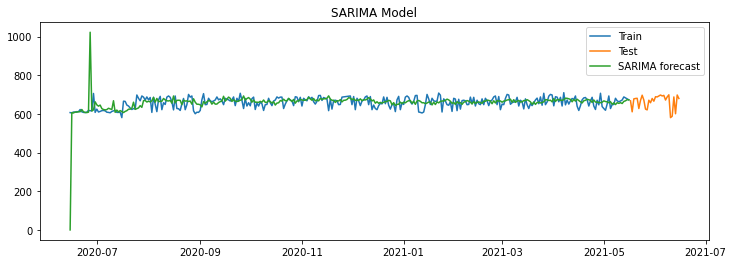

In [204]:
plt.figure(figsize=(12,4))
plt.plot( train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_sarima, label='SARIMA forecast')
plt.legend(loc='best')
plt.title('SARIMA Model')
plt.show()

In [205]:
#RMSE Value
RMSE_SARIMA_train=RMSE(y_hat_sarima,train['Total Beds Available'])

In [206]:
RMSE_SARIMA_train

48.04376325693859

SARIMA for Combined Data

In [207]:
SARIMA_model = SARIMAX(df,order=(0,1,1),seasonal_order=(0,1,1,12),enforce_invertibility=False,
                             enforce_stationarity=False).fit()

In [208]:
y_hat_sarima = SARIMA_model.predict(start = df.index[0],end = df.index[-1], dynamic=False)

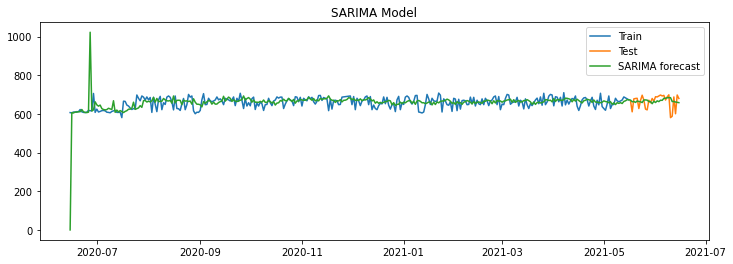

In [209]:
plt.figure(figsize=(12,4))
plt.plot( train['Total Beds Available'], label='Train')
plt.plot(test['Total Beds Available'], label='Test')
plt.plot(y_hat_sarima, label='SARIMA forecast')
plt.legend(loc='best')
plt.title('SARIMA Model')
plt.show()

In [210]:
#RMSE Value
RMSE_SARIMA_data=RMSE(y_hat_sarima,df['Total Beds Available'])

In [211]:
RMSE_SARIMA_data

47.160368205634825